In [1]:
import re
import numpy as np
from plot_log import (
    get_results,
    get_task_model_dict,
    plot_task_results,
    get_ppl_model_dict,
    plot_ppl_results,
    plot_layer_loss,
    plot_task_results_violin,
)

('0', '0', '0.023954108357429504', '0.28997743129730225', '16404.5771484375')
{'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}
('wikitext2', '12.18686580657959')


In [2]:
import pandas as pd
from io import StringIO

prev_method_results = StringIO(
    "\n".join(
        [
            "method,piqa,arc_easy,arc_challenge,boolq,hellaswag,winogrande,avg",
            # "FP16,78.40,67.34,38.13,73.11,56.42,66.85,63.38",
            # "LAE,56.58,28.74,21.84,56.39,27.32,52.72,40.60",
            # "SmoothQuant,61.86,42.42,22.86,58.37,33.30,50.51,44.89",
            # "OmniQuant,63.49,46.17,24.74,62.53,39.58,53.51,48.34",
            "LRQuant,66.64,52.98,28.92,63.30,43.99,53.51,51.56",
        ]
    )
)
df = pd.read_csv(prev_method_results)

prev_task_dict = {}
for i, row in df.iterrows():
    method = row["method"]
    tasks = row.drop("method")
    for task, score in tasks.items():
        if task == "avg":
            continue
        prev_task_dict.setdefault(task, []).append((method, score / 100))

print(prev_task_dict)

{'piqa': [('LRQuant', 0.6664)], 'arc_easy': [('LRQuant', 0.5297999999999999)], 'arc_challenge': [('LRQuant', 0.2892)], 'boolq': [('LRQuant', 0.633)], 'hellaswag': [('LRQuant', 0.4399)], 'winogrande': [('LRQuant', 0.5351)]}


In [3]:
softmax_both = get_results(
    log_dir_path="../log/softmax_both",
    # allowd_models=[
    #     # re.compile('^sw-'),
    #     "base",
    #     re.compile('^ls\.?\d$'),
    # ],
)


softmax_both_task_model_dict = get_task_model_dict(softmax_both)
for task, task_results in softmax_both_task_model_dict.items():
    prev_task_dict[task].append(("sw_both_avg", np.mean([value for _, value in task_results])))
    max_result = None
    for name, value in task_results:
        if max_result is None or value > max_result:
            max_result = value
        if name == "2":
            prev_task_dict[task].append(("sw_both_default_seed", value))
    prev_task_dict[task].append(("sw_both_max", max_result))
    
print(prev_task_dict)

# task_model_dict = get_task_model_dict(softmax_both)
# plot_task_results(task_model_dict)
# ppl_model_dict = get_ppl_model_dict(softmax_both)
# plot_ppl_results(ppl_model_dict)
# plot_layer_loss(softmax_both)

{'piqa': [('LRQuant', 0.6664), ('sw_both_avg', 0.6635836053681538), ('sw_both_default_seed', 0.6572361262241567), ('sw_both_max', 0.676278563656148)], 'arc_easy': [('LRQuant', 0.5297999999999999), ('sw_both_avg', 0.5037177328843996), ('sw_both_default_seed', 0.494949494949495), ('sw_both_max', 0.5298821548821548)], 'arc_challenge': [('LRQuant', 0.2892), ('sw_both_avg', 0.29109783845278725), ('sw_both_default_seed', 0.27986348122866894), ('sw_both_max', 0.30631399317406144)], 'boolq': [('LRQuant', 0.633), ('sw_both_avg', 0.6265545361875637), ('sw_both_default_seed', 0.6223241590214067), ('sw_both_max', 0.6333333333333333)], 'hellaswag': [('LRQuant', 0.4399), ('sw_both_avg', 0.4258779791542189), ('sw_both_default_seed', 0.424815773750249), ('sw_both_max', 0.4326827325234017)], 'winogrande': [('LRQuant', 0.5351), ('sw_both_avg', 0.5399894764535649), ('sw_both_default_seed', 0.5674822415153907), ('sw_both_max', 0.5674822415153907)]}


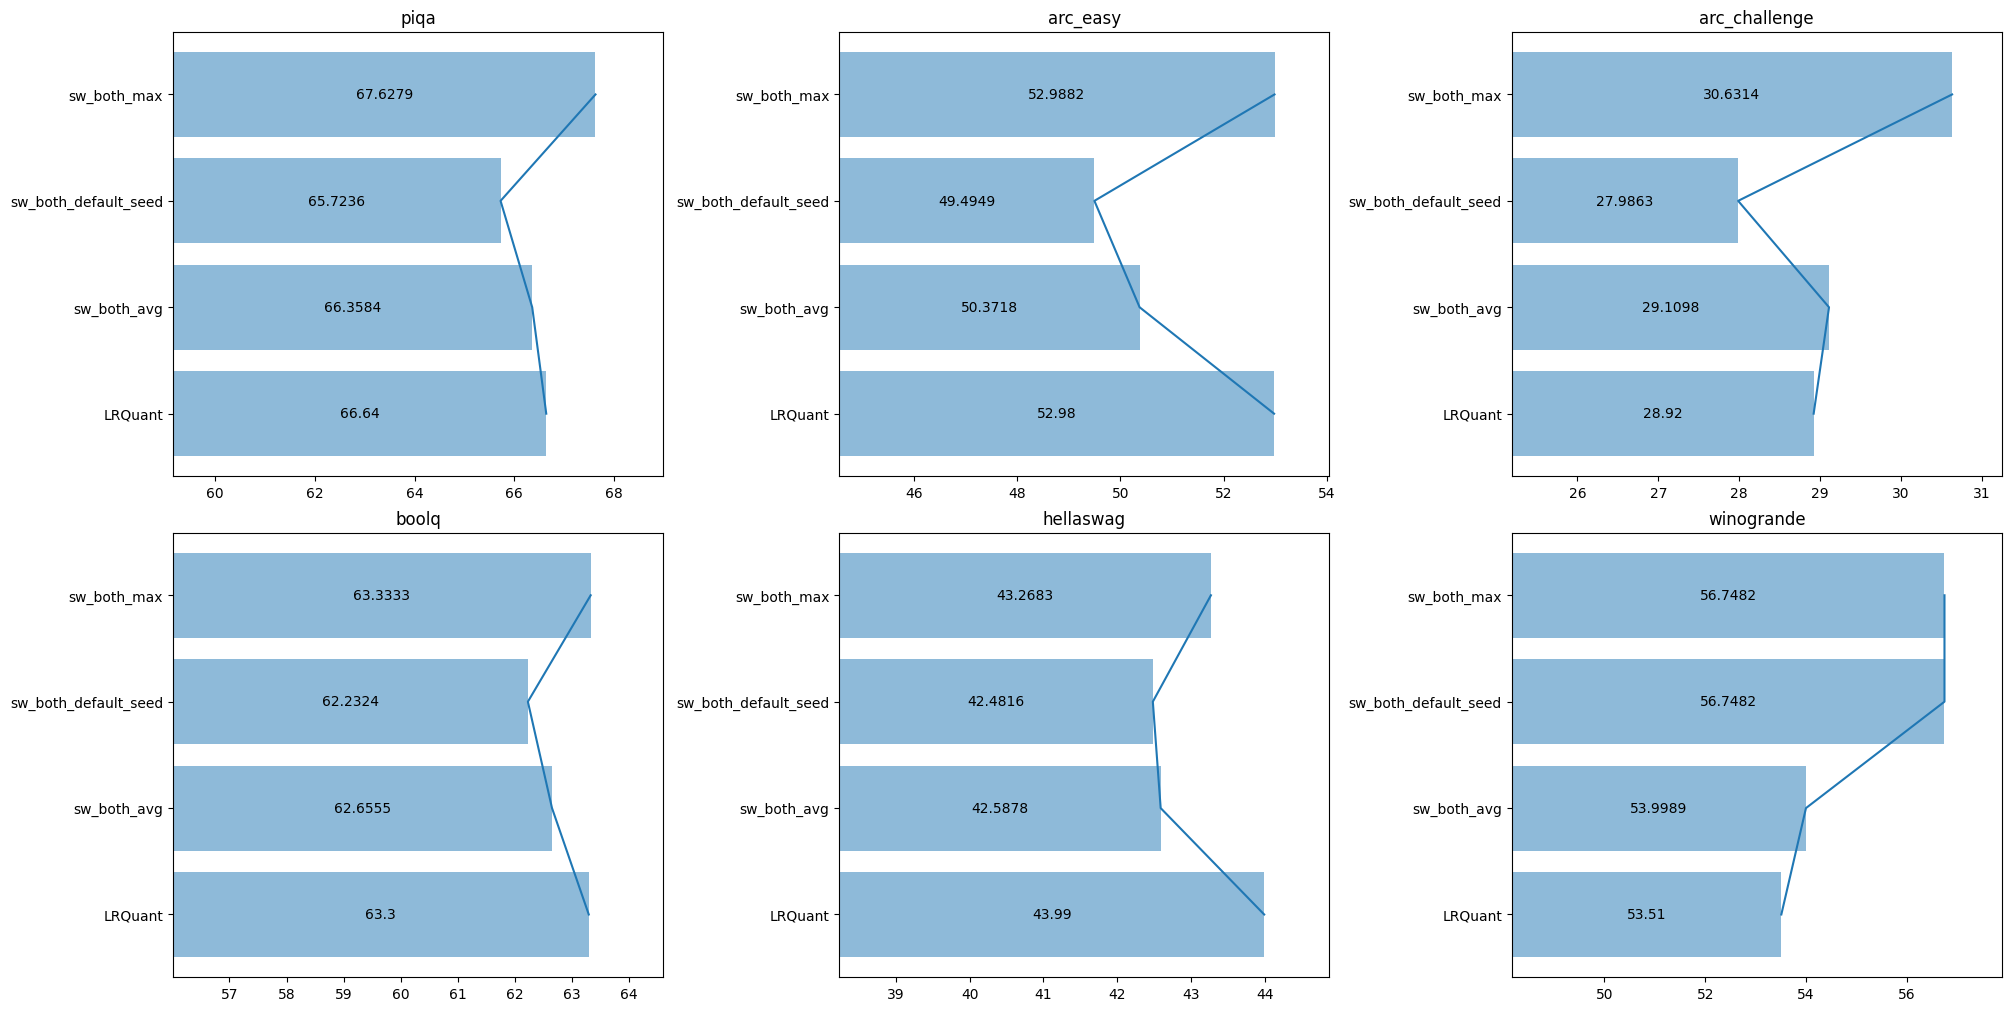

In [4]:
plot_task_results(prev_task_dict, padding_right=0.02)

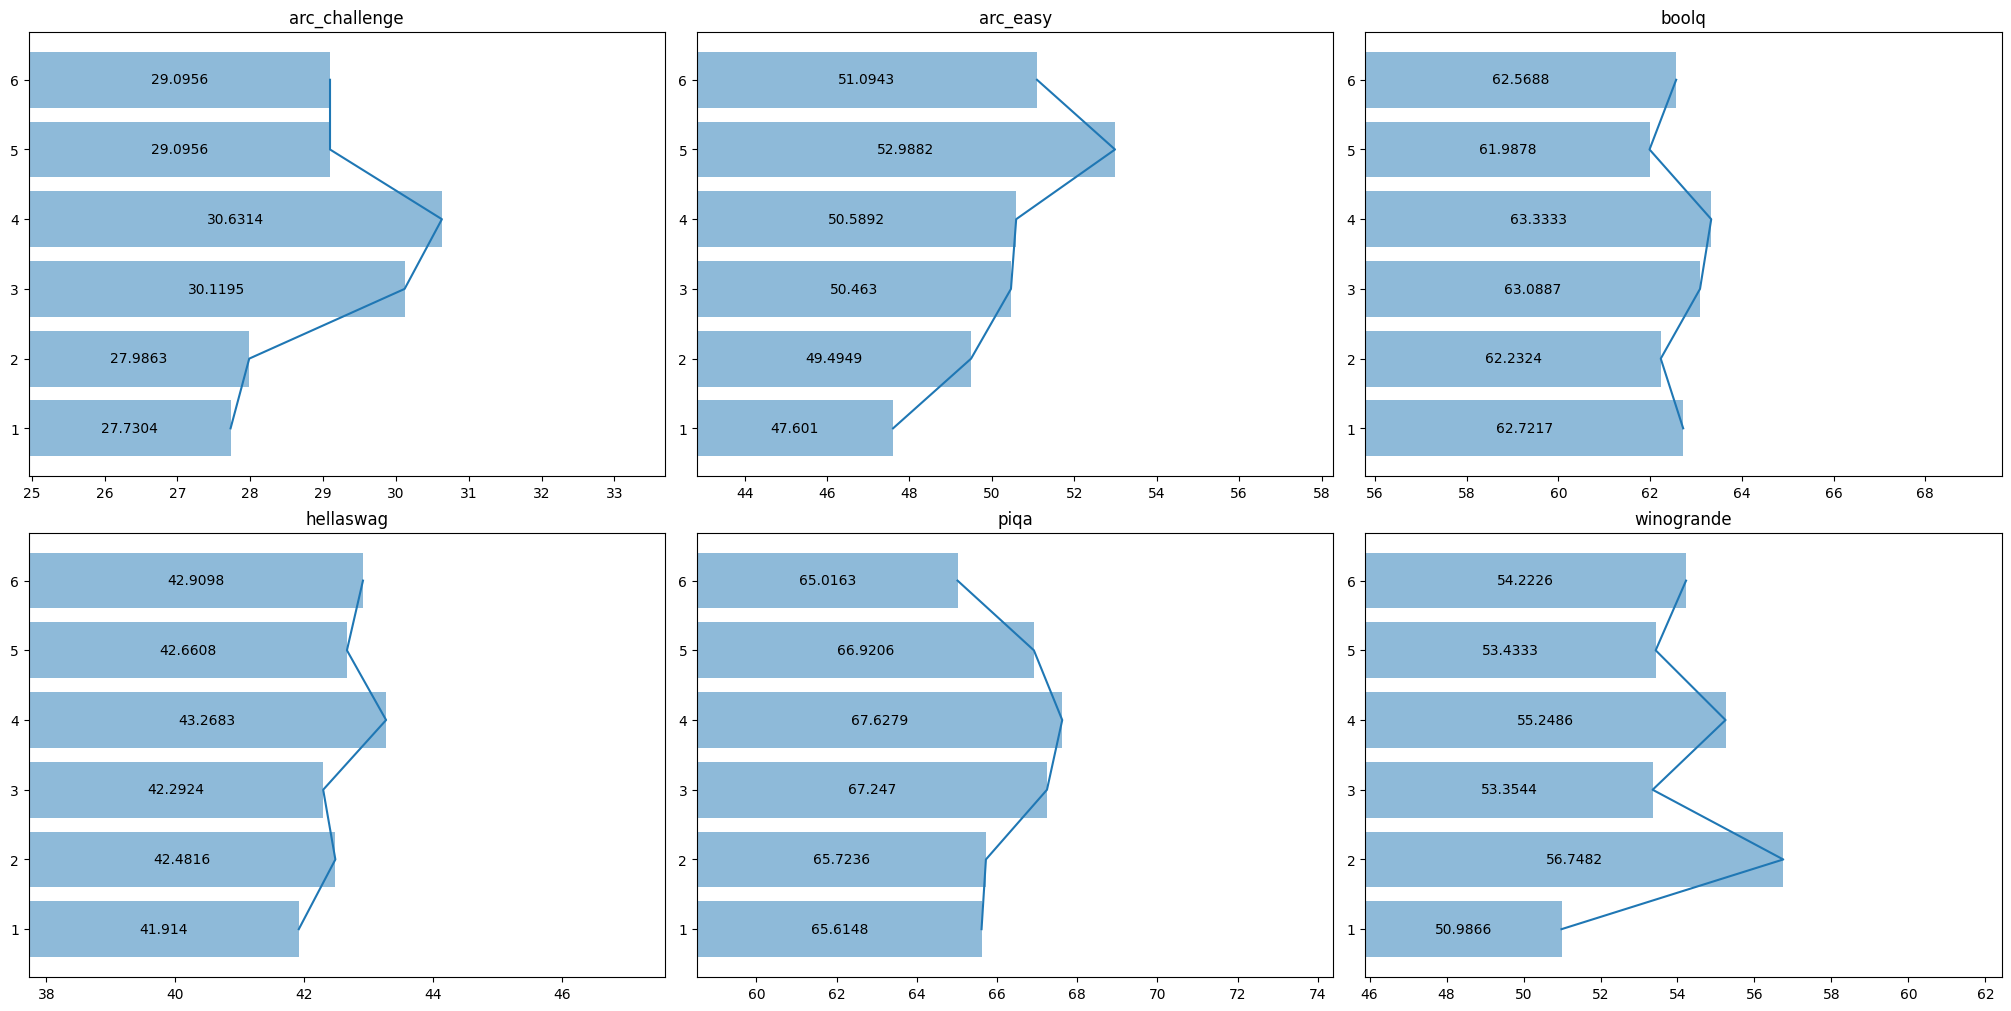

In [6]:
# plot_task_results_violin(get_task_model_dict(softmax_both))
plot_task_results(get_task_model_dict(softmax_both))